In [2]:
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt

import gc_turbulence as g

%matplotlib inline

/nfs/see-fs-02_users/eeaol/src/anaconda/envs/thesis/lib/python2.7/site-packages/matplotlib/__init__.py:1312: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
index = 'r14_01_14a'
cache_path = g.default_processed + index + '.hdf5'
r = g.ProcessedRun(cache_path=cache_path)

u_levels = np.linspace(*np.percentile(r.Uf[...], (1, 99)), num=100)

tf = r.Tf[:, 0, :]
zf = r.Zf[:, 0, :]

Below is the mean of the data in the front relative frame. At this point the data looks as we might expect.

<matplotlib.colorbar.Colorbar instance at 0x2b4970c4fb90>

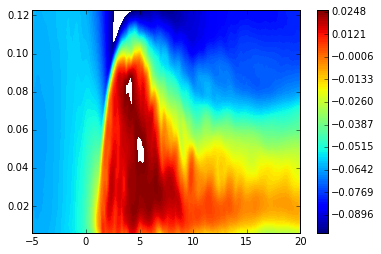

In [4]:
mean = np.mean(r.Uf[...], axis=1)
plt.contourf(tf, zf, mean, levels=u_levels)
plt.colorbar()

However if we consider a single data slice in the front relative frame we can see what appear to be background waves.

<matplotlib.colorbar.Colorbar instance at 0x2b49765c3ab8>

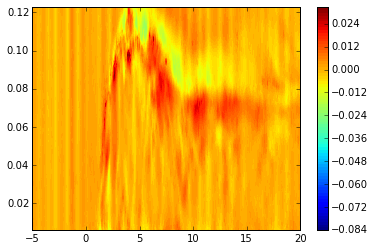

In [5]:
mean_subtracted = r.Uf[...] - mean[..., None, ...]
c = plt.contourf(tf, zf, mean_subtracted[:, 30, :], 100)
plt.colorbar()

We don't see these waves in the front relative mean because they average out over the width of the observation window.

Here is a plot in the lab frame, from a single height.

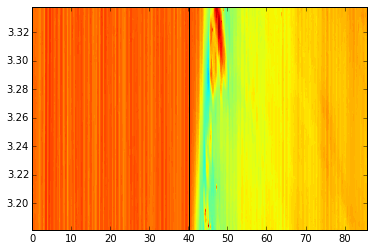

In [6]:
mean_u = np.mean(r.U[-10:, :, :], axis=0)
Te = r.T[0, :, :]
plt.contourf(Te, r.X[0], mean_u, levels=u_levels)

x = r.X[0, :, 0]
plt.plot((0.14 / x) + 40, x, 'k')

We can see that the waves are very fast, compared to the front speed. Importantly, these waves don't appear to be causally related to the current.

A possible source of the waves is residual motion from filling the tank, but we will look at this more later.

We will treat them as background noise that needs to be removed. Leaving these waves in the data will cloud any frequency analysis that we wish to do.

Let's consider a timeseries from a single point in $(x, z)$.

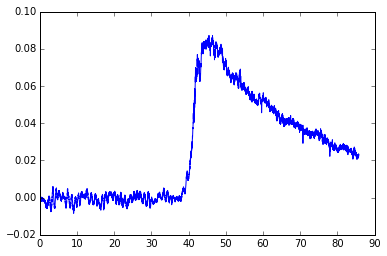

In [7]:
signal = r.U[10, 10, :]
time = r.T[10, 10, :]
plt.plot(time, signal)

Now let's look at the portion before the front onset:

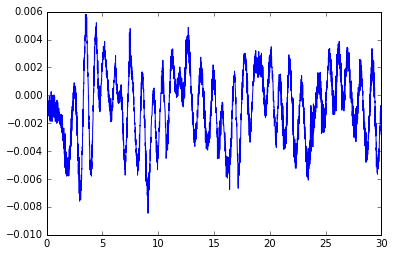

In [8]:
presignal = r.U[10, 10, :3000]
plt.plot(time[:3000], presignal)

It appears that there are several wave frequencies represented here, as revealed by the frequency power spectrum:

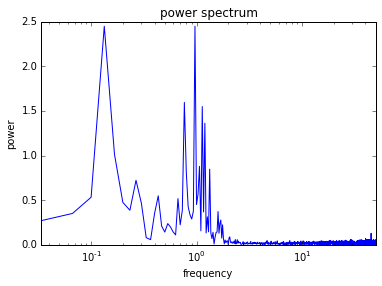

In [9]:
fft = np.fft.rfft(presignal)
freqs = np.fft.rfftfreq(presignal.size, d=0.01)

plt.semilogx(freqs, np.abs(fft))
plt.xlabel('frequency')
plt.ylabel('power')
plt.title('power spectrum')

fmin = 1 / (time[:3000].max() - time[:3000].min())
fmax = 100 / 2
plt.xlim(fmin, fmax);

There apears to be a harmonic series beginning at ~0.1Hz, along with a cluster of frequencies about 1Hz.

We can increase the quality of our power spectrum, at least for the harmonic series, by increasing the frequency resolution and by using a more appropriate windowing function on our signal.

An appropriate windowing function will minimise spectral leakage from the frequency components that make up the signal. We have implicitly used a uniform rectangular window but a more appropriate choice would be a Hanning window, which has smoothly decreasing side lobes.

The implicit default is a uniform, boxcar, window which has non monotonic side lobes.

/nfs/see-fs-02_users/eeaol/src/anaconda/envs/thesis/lib/python2.7/site-packages/IPython/kernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log10


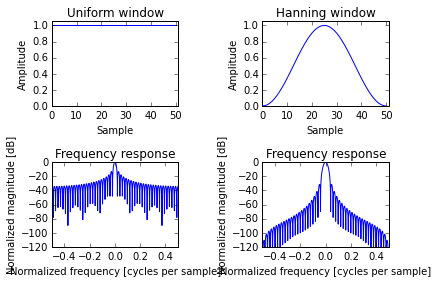

In [10]:
import scipy.signal as sig

def plot_window(ax, window, name):
    ax.plot(window)
    ax.axis([0, len(window), 0, 1.05])
    ax.set_title("{} window".format(name))
    ax.set_ylabel("Amplitude")
    ax.set_xlabel("Sample")

def plot_frequency_response(ax, window):
    A = np.fft.fft(window, 2048) / (len(window)/2.0)
    freq = np.linspace(-0.5, 0.5, len(A))
    response = 20 * np.log10(np.abs(np.fft.fftshift(A / abs(A).max())))

    ax.plot(freq, response)
    ax.axis([-0.5, 0.5, -120, 0])
    ax.set_title("Frequency response")
    ax.set_ylabel("Normalized magnitude [dB]")
    ax.set_xlabel("Normalized frequency [cycles per sample]")

fig, axes = plt.subplots(nrows=2, ncols=2)

hanning = sig.hanning(51)
boxcar = sig.boxcar(51)

plot_window(axes[0, 0], boxcar, 'Uniform')
plot_frequency_response(axes[1, 0], boxcar)

plot_window(axes[0, 1], hanning, 'Hanning')
plot_frequency_response(axes[1, 1], hanning)

fig.tight_layout()

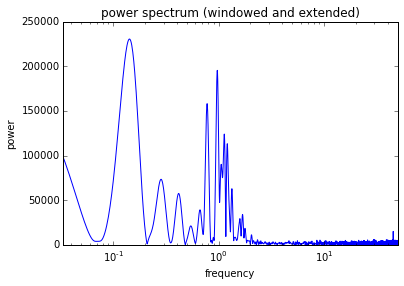

In [61]:
extended = np.zeros(presignal.size * 20)
extended[:presignal.size] = presignal * sig.hanning(presignal.size)

extended_fft = np.fft.rfft(extended)
extended_freqs = np.fft.rfftfreq(extended.size, d=0.01)

plt.semilogx(extended_freqs, np.abs(extended_fft) / presignal.var())
plt.xlim(fmin, fmax)

plt.title('power spectrum (windowed and extended)')
plt.xlabel('frequency')
plt.ylabel('power');

One hypothesis for the cause of the frequency peaks is standing waves in the tank. The tank is filled with a hose at one end of the tank. In the single layer runs examined here this is done at high speed. The overpressure at the hose inlet would be a sufficient perturbation to excite a series of standing waves.

The phase velocity of linear waves in shallow water is

$$
c_p = \sqrt{gH}
$$

The frequencies of standing waves are

$$
f_n = \frac{nc_p}{2L}
$$

The full length of the tank is $L = 5.50 \pm{0.005} \mathrm{m}$ and the height $H = 0.25 \pm{0.005} \mathrm{m}$, giving a base frequency of $f_1 = 0.142 \pm{0.001} \mathrm{Hz}$.

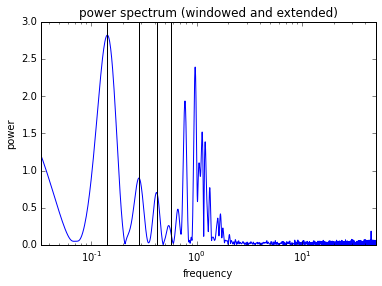

In [62]:
plt.semilogx(extended_freqs, 2 * np.abs(extended_fft))
plt.xlim(fmin, fmax)

plt.title('power spectrum (windowed and extended)')
plt.xlabel('frequency')
plt.ylabel('power')


f1 = 0.142
standing_frequencies = f1 * np.arange(1, 4)

def plot_standing_frequencies(f1=f1, n=4):
    for n in range(1, n + 1):
        plt.axvline(n * f1, color='k')
        
plot_standing_frequencies()

The correlation of the predicted standing wave frequencies with the power spectrum peaks suggests that our standing wave hypothesis is true.

To reconstruct the standing waves construct sine waves, taking the phase, frequency and amplitude from the first three peaks of the power spectrum. Higher order standing waves do not appear to contribute significantly to the power spectrum.

In [18]:
peaks = sig.find_peaks_cwt(-np.abs(extended_fft), np.logspace(np.log(0.03), np.log(0.3), 100))

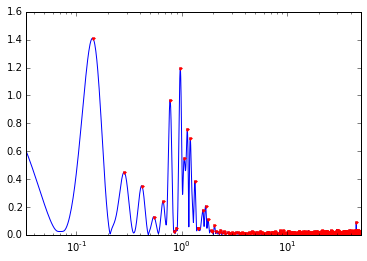

In [19]:
plt.semilogx(extended_freqs, np.abs(extended_fft))
plt.xlim(fmin, fmax)
plt.plot(extended_freqs[peaks], np.abs(extended_fft)[peaks], 'r.')

In [21]:
# factor of 2 comes in because we're using the real fft
standing_waves = ((2.0 / sig.hanning(presignal.size).sum()) * extended_fft[None, peaks[:3]] * np.exp(2j * np.pi * extended_freqs[None, peaks[:3]] * time[:, None])).real
standing_waves_exact = ((2.0 / sig.hanning(presignal.size).sum()) * extended_fft[None, peaks[:3]] * np.exp(2j * np.pi * standing_frequencies[None] * time[:, None])).real

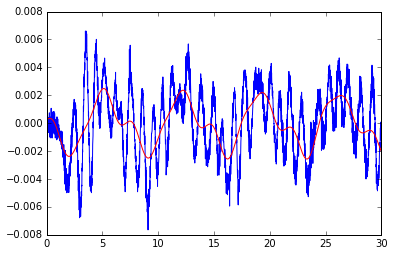

In [134]:
plt.plot(time[:3000], presignal - presignal.mean())
plt.plot(time[:3000], standing_waves.sum(axis=1)[:3000], 'r')

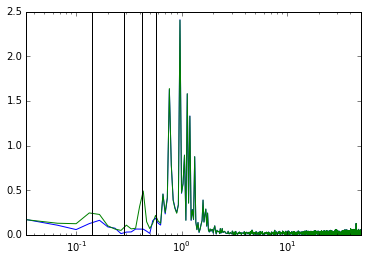

In [23]:
plt.semilogx(freqs, np.abs(np.fft.rfft(presignal - standing_waves.sum(axis=1)[:3000])))
plt.semilogx(freqs, np.abs(np.fft.rfft(presignal - standing_waves_exact.sum(axis=1)[:3000])))
plt.xlim(fmin, fmax)

plot_standing_frequencies()

Extending these waves throughout the run allows us to subtract the standing waves from the full data field.

<matplotlib.contour.QuadContourSet instance at 0x2b498848a098>

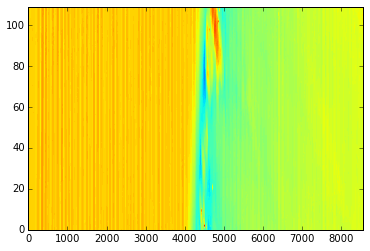

In [26]:
plt.contourf(mean_u - standing_waves.sum(axis=1), 100)

We are now left with the waves deriving from the cluster of frequencies. We can look at the wavelet transform to investigate this further.

The wavelet transform of the pre-front signal is shown below.

In [27]:
import wavelets

wt = wavelets.WaveletTransform(presignal, dt=0.01)

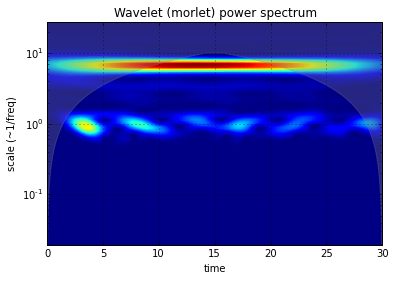

In [28]:
wt.plot_power()
plt.xlabel('time')
plt.ylabel('scale (~1/freq)')
plt.title('Wavelet (morlet) power spectrum');

The harmonic series has frequencies that are represented all through the timeseries, but the cluster is more complicated and has *time dependent form*.

**In particular, we cannot hope to recover the signal simply by summing the peaks of the fourier transform** as we did with the standing waves.

The cause of the cluster of peaks is much harder to determine. Speculatively, it could be an instrumental effect, surface waves induced by the lock release or vibrations in the tank structure.

Interestingly, the cluster of peaks appears to have the same time dependent form across multiple runs.

One feature of the waves is that they are symmetric across all x, z (or near enough, given how fast they are). This is not a property that is shared by the current.

If we can find a way to extract these symmetric features then we might be able to recover the wave signal.

A first guess would be to take the mean across x, z and hope that all other features cancel out leaving the wave signal.

This doesn't work. There is too much spectral contribution from the current at frequencies that would not be expected to average to zero over the observation window.

We can filter out these larger scale disturbances with a high pass filter. Let's filter out frequencies below 0.7Hz. It is somewhere lower than this that frequencies have wavelengths on the order of the observation window size, i.e. will likely not be averaged out.

<matplotlib.contour.QuadContourSet instance at 0x2b49f5db8368>

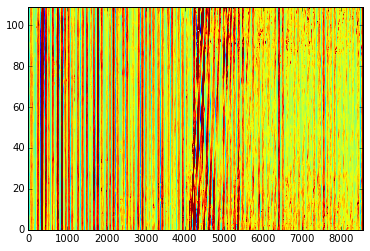

In [137]:
all_x_fft = np.fft.rfft(r.U[10, :, :], axis=-1)
all_freq = np.fft.rfftfreq(r.U.shape[-1], d=0.01)

rfft = all_x_fft.copy()
rfft[:, all_freq < 0.7] = 0
rdata = np.fft.irfft(rfft, axis=-1)

levels = np.linspace(*np.percentile(rdata, (1, 99)))
plt.contourf(rdata, levels=levels)

If we now average in x (recovering the DC component, equivalent to applying a super low pass filter), we can recover the time-dependent signal:

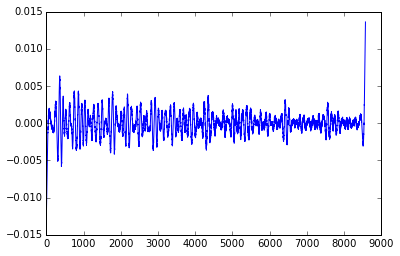

In [147]:
rsignal = rdata.mean(axis=0)
plt.plot(rsignal)

It is tempting to average over z as well, but the validity of this depends on $u$ having no $z$ dependency. This would be the case with a frictionless bottom surface, but we cannot make this assumption here.

We must assume that the signal has z-dependent form.

In [138]:
all_x_fft = np.fft.rfft(r.U[:, :, :], axis=-1)
all_freq = np.fft.rfftfreq(r.U.shape[-1], d=0.01)

rfft = all_x_fft.copy()
rfft[:, :, all_freq < 0.7] = 0  
ardata = np.fft.irfft(rfft, axis=-1)

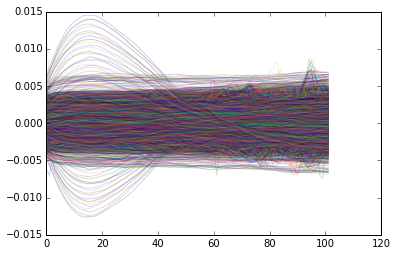

In [146]:
zsignal = ardata.mean(axis=1)
plt.plot(zsignal, alpha=0.2);

The wavelet transform of the recovered signal suggests that we have been successful in isolating the time dependent behaviour.

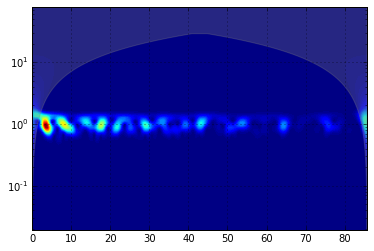

In [148]:
wavelets.WaveletTransform(rsignal, dt=0.01).plot_power()

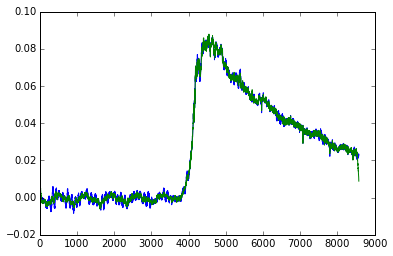

In [149]:
plt.plot(signal)
plt.plot(signal - rsignal)

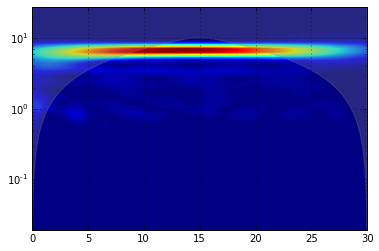

In [34]:
wavelets.WaveletTransform((signal - rsignal)[:3000], dt=0.01).plot_power()

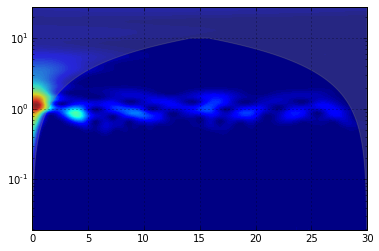

In [35]:
wavelets.WaveletTransform((signal - rsignal - standing_waves.sum(axis=1))[:3000], dt=0.01).plot_power()

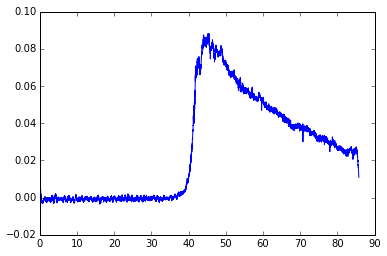

In [36]:
plt.plot(time, signal - rsignal - standing_waves.sum(axis=1))

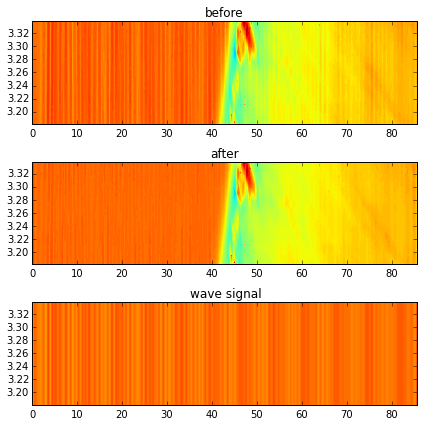

In [37]:
fig, axes = plt.subplots(nrows=3, figsize=(6, 6))

axes[0].set_title('before')
axes[0].contourf(Te, r.X[0], mean_u, levels=u_levels)

axes[1].set_title('after')
axes[1].contourf(Te, r.X[0], mean_u - rsignal - standing_waves.sum(axis=1), levels=u_levels)

axes[2].set_title('wave signal')
axes[2].contourf(Te, r.X[0], np.tile(rsignal + standing_waves.sum(axis=1), (mean_u.shape[0], 1)), levels=u_levels)

fig.tight_layout();

### Summary

The data is obscured by waves that can be split into standing waves and time-dependent waves.

1. Using the pre front signal, identify the first three standing wave components in the power spectrum.

2. Using the full time signal, apply a high pass filter and average over x to obtain the time-dependent waves.

<matplotlib.contour.QuadContourSet instance at 0x2b4b295eac20>

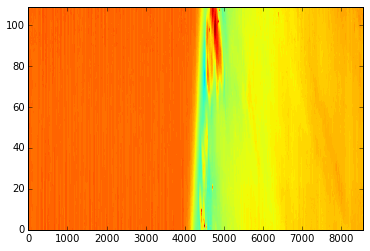

In [238]:
def find_nearest_idx(array,value):
    return (np.abs(array-value)).argmin()

def extract_standing_signal(velocity, front_index, time, dt):
    # pull out the pre-front signal
    presignal = velocity[:, :, :front_index - 500].mean(axis=0).mean(axis=0)
    
    # bandpass to only permit standing waves
    standing_signal = bandpass(presignal, 0.1, 0.7)
    
    # zero pad and window to increase frequency resolution   
    window = sig.hanning(standing_signal.size)
    extended = np.zeros(standing_signal.size * 20)
    extended[:standing_signal.size] = standing_signal * window
    
    # compute the fft
    extended_freqs = np.fft.rfftfreq(extended.size, d=dt)
    extended_fft = np.fft.rfft(extended)
    
    extended_power = np.abs(extended_fft)
     
    # find the maxima in the power spectrum
    maxima = sig.argrelextrema(extended_power, np.greater)

    maxima_freqs = np.zeros(extended_freqs.shape)
    maxima_freqs[maxima] = extended_freqs[maxima]
    
    # determine the peaks as the closest maxima to each of the standing wave frequencies
    peak_indices = [find_nearest_idx(maxima_freqs, f) for f in standing_frequencies]
    
    # now construct the standing waves over the full time series
    norm = 2.0 / window.sum()
    standing_amplitude = extended_fft[peak_indices]
    standing_frequency = extended_freqs[peak_indices]
    
    standing_waves = norm * standing_amplitude[None] * np.exp(2j * np.pi * standing_frequency[None] * time[:, None])
    
    return standing_waves.real


def extract_cluster_signal(velocity):
    mean_signal = velocity[:].mean(axis=0).mean(axis=0)
    return bandpass(mean_signal, 0.7)

def extract_waves(run):
    front_index = int(np.min(run.ft) / run.dt)
    time = run.T[0, 0, :]
    
    sw = extract_standing_signal(r.U, front_index, time, r.dt).sum(axis=1)
    cs = extract_cluster_signal(r.U)
    
    return cs + sw

plt.contourf(mean_u - extract_waves(r), levels=u_levels)

This gives us the u-component of the waves. We also need the w component.



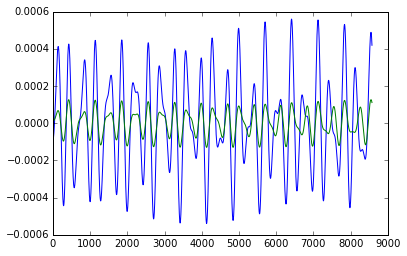

In [281]:
def uw_ratio(f):
    d = 0.25
    g = 9.81
    cp = (g * d) ** .5
    tau = 2 * np.pi
    
    x = 3.2
    
    return (1 / tau) * (cp / f) * (1 / d) * np.tan(tau * f * x / cp)

w_waves = standing_waves / uw_ratio(standing_frequencies)

plt.plot(w_waves.sum(axis=1))
plt.plot(-ww)

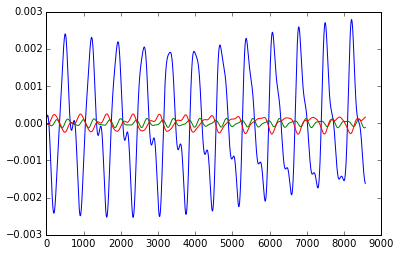

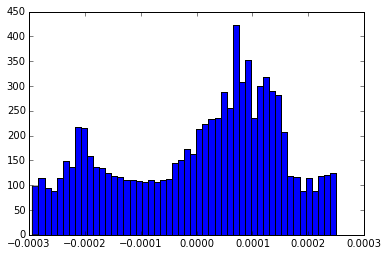

In [268]:
def extract_waves_w(run):
    front_index = int(np.min(run.ft) / run.dt)
    time = run.T[0, 0, :]
    
    sw = extract_standing_signal(r.W, front_index, time, r.dt).sum(axis=1)
    cs = extract_cluster_signal(r.W)
    
    return sw

def extract_waves_v(run):
    front_index = int(np.min(run.ft) / run.dt)
    time = run.T[0, 0, :]
    
    sw = extract_standing_signal(r.V[-10:], front_index, time, r.dt).sum(axis=1)
    cs = extract_cluster_signal(r.V[-10:])
    
    return sw

ww = extract_waves_w(r)
wv = extract_waves_v(r)

plt.plot(sw)
plt.plot(ww)
plt.plot(wv)

plt.figure()
plt.hist(wv, bins=50);

We would expect the v component to be exactly zero due to the symmetry of the tank. The histogram should be symmetric about a mean of zero.

### z dependence of standing waves

With a non-slip bottom, the $u$ velocity component must have height dependent form.

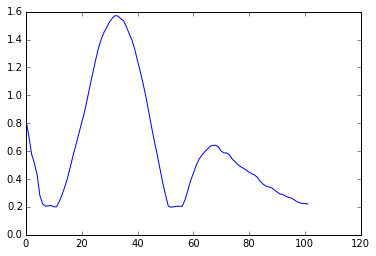

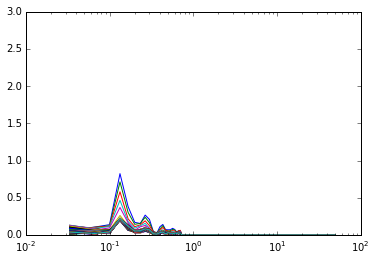

In [251]:
apresignal = r.V[:, :, :3000].mean(axis=1)

afreqs = np.fft.rfftfreq(apresignal.shape[-1], d=0.01)
afft = np.fft.rfft(apresignal, axis=-1)
afft[:, afreqs > 0.7] = 0

plt.figure()
plt.plot(np.abs(afft).max(axis=1))

plt.figure()

plt.semilogx(afreqs, np.abs(afft).T);
plt.ylim(0, 3);

## Deriving the waves from the full current data.

Take the fourier transform peak. There probably isn't a phase change on collision with the front.

We can increase the resolution of the peak by using e.g. a cosine taper (have used kaiser before) along with zero padding the signal.

If the big wave is a standing wave in the tank then Locko can't see why there would be a phase change on reaching the current front.

If there is no phase change then we can look at the peak of the fourier transform and use this to construct the sinusoidal wave to subtract.

If there is a phase change then the problem becomes more complicated.

Another possibility is aliasing from high frequencies.

Side note: 2 pole butterworth would be better filter to use than the boxcar that I'm using now. Might not be necessary, just be mindful of a sinc function at the frequency of the boxcar edge convolved with the data.

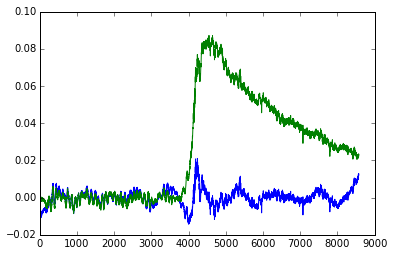

In [38]:
def bandpass(signal, cutoff, high_cutoff=False):
    fft = np.fft.rfft(signal, axis=-1)
    freqs = np.fft.rfftfreq(signal.size, d=0.01)
    
    rfft = fft.copy()
    rfft[freqs < cutoff] = 0
    
    if high_cutoff:
        rfft[freqs > high_cutoff] = 0
        
    rdata = np.fft.irfft(rfft)
    return rdata
    

plt.plot(bandpass(signal, 0.09))
plt.plot(signal)

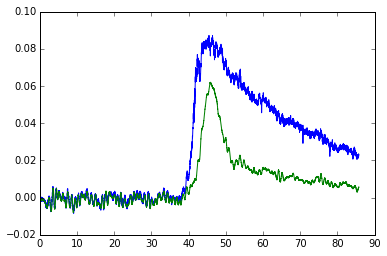

In [39]:
plt.plot(time, signal)
plt.plot(time, mean_signal)

[ 5.09232421  1.2861495   0.83687633]
[ 2.38480695 -1.83259713 -1.50965616]
[ 1.40971606  0.44940869  0.35249477]
[ 1.44460702 -1.73535698 -1.35213204]
[ 0.142  0.284  0.426]
[ 0.14284049  0.2839319   0.41861007]


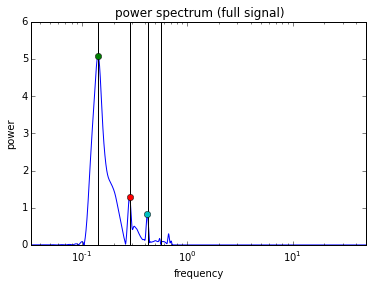

In [113]:
mean_signal = r.U[:, :, :].mean(axis=0).mean(axis=0)

full_window = sig.hanning(mean_signal.size)

full_extended = np.zeros(mean_signal.size * 20)
full_extended[:mean_signal.size] = bandpass(mean_signal, 0.12, 0.7) * full_window

full_fft = np.fft.rfft(full_extended)
full_freqs = np.fft.rfftfreq(full_extended.size, d=0.01)

plt.semilogx(full_freqs, np.abs(full_fft))


plt.xlim(fmin, fmax)

plt.title('power spectrum (full signal)')
plt.xlabel('frequency')
plt.ylabel('power');

plot_standing_frequencies()

maxima = sig.argrelextrema(np.abs(full_fft), np.greater)

maxima_freqs = np.zeros(full_freqs.shape)
maxima_freqs[maxima] = full_freqs[maxima]

def find_nearest_idx(array,value):
    return (np.abs(array-value)).argmin()

peak_indices = [find_nearest_idx(maxima_freqs, f) for f in standing_frequencies]

for idx in peak_indices:
    plt.plot(full_freqs[idx], np.abs(full_fft[idx]), 'o')

print np.abs(full_fft[peak_indices])
print np.angle(full_fft[peak_indices])

print np.abs(extended_fft[peaks[:3]])
print np.angle(extended_fft[peaks[:3]])

print standing_frequencies
print full_freqs[peak_indices]

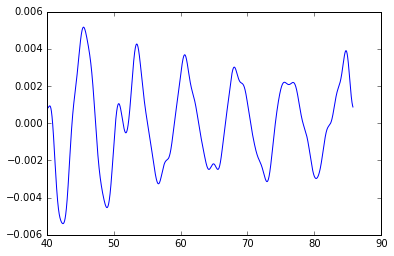

In [107]:
plt.plot(time[4000:], bandpass(mean_signal, 0.12, 0.7))

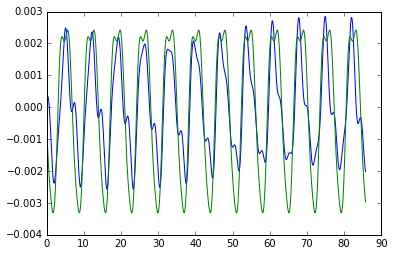

In [112]:
standing_waves_full = ((2.0 / full_window.sum()) * full_fft[None, peak_indices] * np.exp(2j * np.pi * standing_frequencies[None] * time[:, None])).real

plt.plot(time, standing_waves.sum(axis=1))
plt.plot(time, standing_waves_full.sum(axis=1))

When we find the maxima by using the full data field we encounter a problem. We expect a broad range of frequencies in the gravity current, which will include the frequencies of the standing waves. The recovered standing wave amplitudes will appear greater than they actually are due to contributions to the spectral power from the gravity current.

To overcome this we smooth out the power spectrum, ignoring a band around each standing wave frequency.

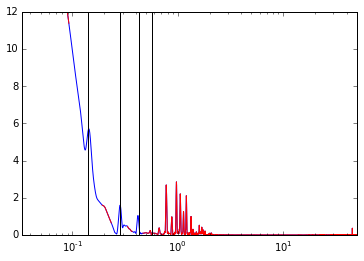

In [114]:
mean_signal = r.U[:, :, :].mean(axis=0).mean(axis=0)

full_extended_smooth = np.zeros(mean_signal.size * 20)
full_extended_smooth[:mean_signal.size] = mean_signal * sig.cosine(mean_signal.size)

full_smooth_fft = np.fft.rfft(full_extended_smooth)
full_smooth_freqs = np.fft.rfftfreq(full_extended_smooth.size, d=0.01)

plt.xlim(fmin, fmax)
plt.ylim(0, 12)
plt.semilogx(full_smooth_freqs, np.abs(full_smooth_fft))

width = int(0.05 / np.diff(full_smooth_freqs)[0])

exclude_peaks = full_smooth_fft.copy()
for idx in peak_indices:
    exclude_peaks[np.arange(idx - width, idx + width)] = np.nan

plt.semilogx(full_smooth_freqs, np.abs(exclude_peaks), 'r')

plot_standing_frequencies()

plt.plot(full_smooth_freqs, full_smooth_freqs * -5/3)

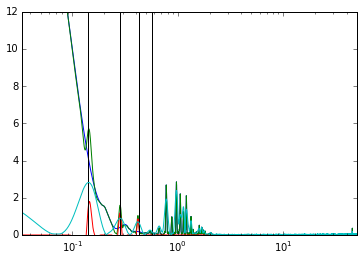

In [67]:
import scipy.interpolate as interp

fft_background = np.abs(exclude_peaks)

nans = np.isnan(fft_background)
ignored = (full_smooth_freqs > 0.7) | nans

background_power = interp.interp1d(full_freqs[~ignored], fft_background[~ignored], kind='cubic')

fft_background[nans] = background_power(full_freqs[nans])

plt.semilogx(full_freqs, fft_background)
plt.semilogx(full_freqs, np.abs(full_smooth_fft))
plt.semilogx(full_freqs, np.abs(full_smooth_fft) - fft_background)

plt.xlim(fmin, fmax)
plt.ylim(0, 12)

plt.semilogx()

plot_standing_frequencies()

plt.semilogx(extended_freqs, 2 * np.abs(extended_fft))

If we want to interpolate over the fourier transform then we need to interpolate over the phase as well as the amplitude.

Interpolating over the complex plane is impossible in general, but if we look at the behaviour of the phase we can see a pattern: the phase appears to follow a linear trajectory.

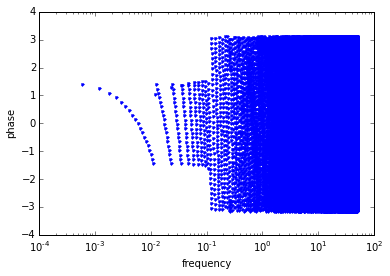

In [56]:
plt.semilogx(full_freqs, np.angle(full_fft), '.')
plt.xlabel('frequency')
plt.ylabel('phase')

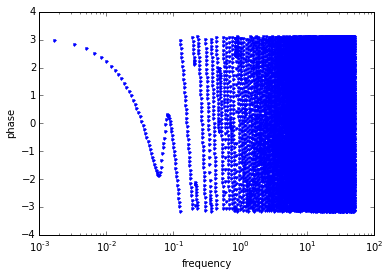

In [372]:
plt.semilogx(extended_freqs, np.angle(extended_fft), '.')
plt.xlabel('frequency')
plt.ylabel('phase')

We can unravel this:

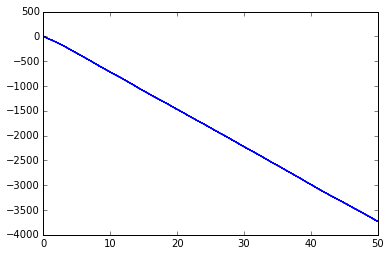

In [377]:
phase = np.angle(full_fft)
unphased = phase.copy()
jumps = np.where(np.diff(phase) > (2 * np.pi - 1))[0]

for jump in jumps:
    unphased[jump:] = unphased[jump:] - np.pi / 2
    
plt.plot(full_freqs, unphased)

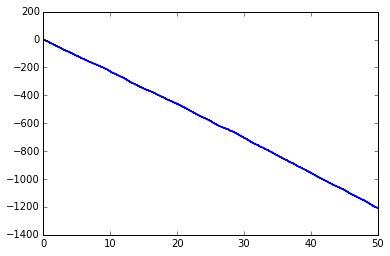

In [376]:
phase = np.angle(extended_fft)
unphased = phase.copy()
jumps = np.where(np.diff(phase) > (2 * np.pi - 1))[0]

for jump in jumps:
    unphased[jump:] = unphased[jump:] - np.pi / 2
    
plt.plot(extended_freqs, unphased)

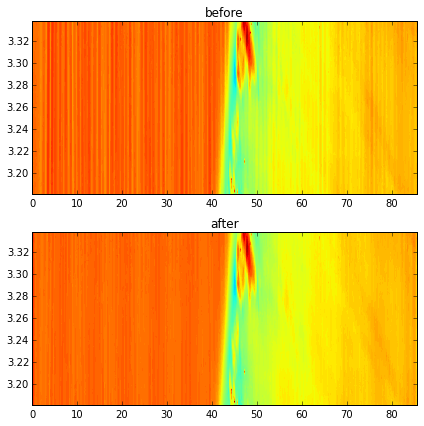

In [322]:
fig, axes = plt.subplots(nrows=2, figsize=(6, 6))

axes[0].set_title('before')
axes[0].contourf(Te, r.X[0], mean_u, levels=u_levels)

axes[1].set_title('after')
axes[1].contourf(Te, r.X[0], mean_u - rsignal - standing_waves_full.sum(axis=1), levels=u_levels)

fig.tight_layout();

/nfs/see-fs-02_users/eeaol/src/anaconda/envs/thesis/lib/python2.7/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


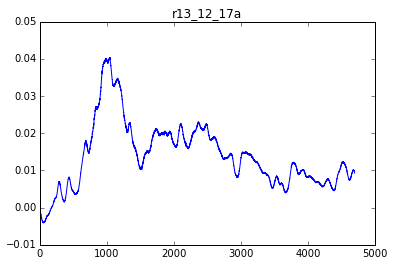

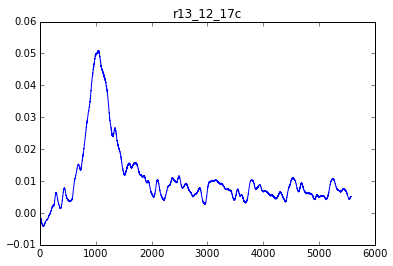

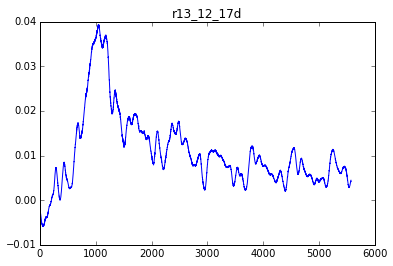

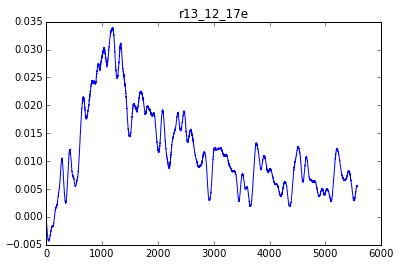

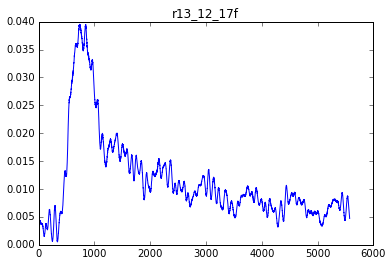

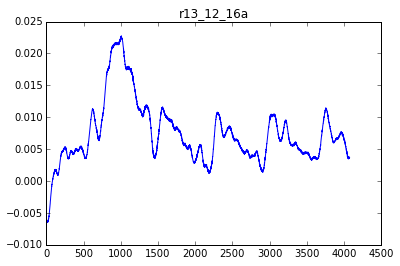

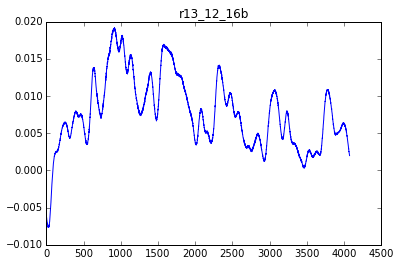

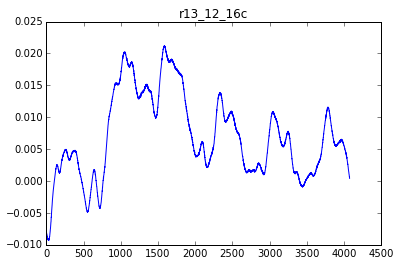

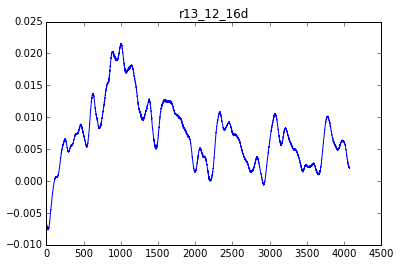

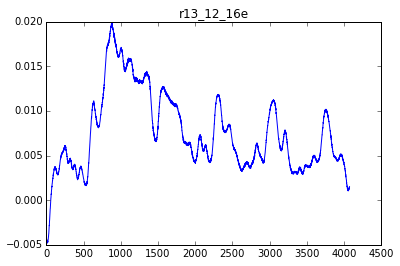

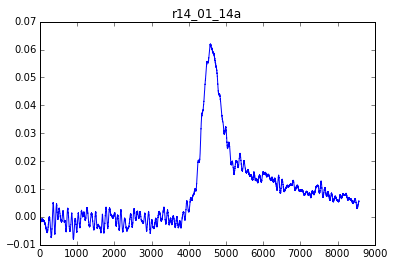

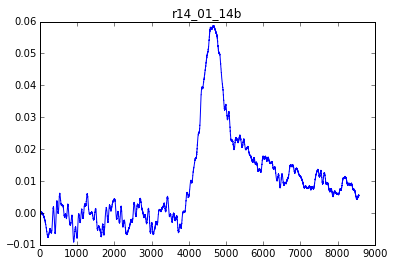

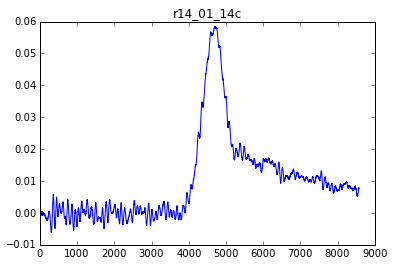

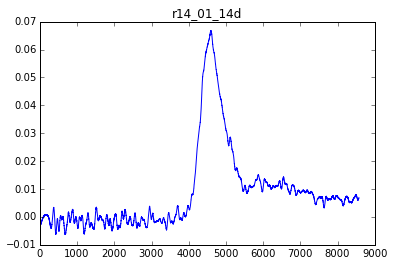

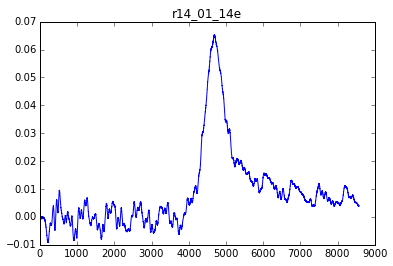

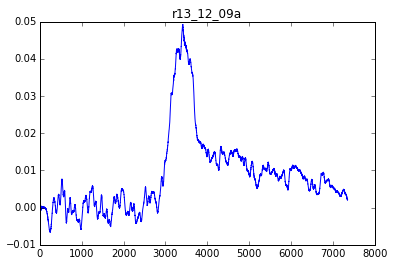

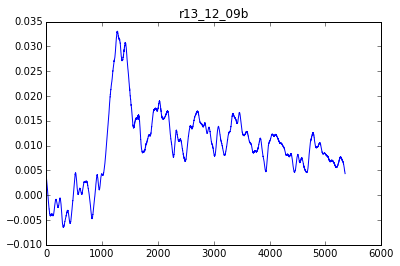

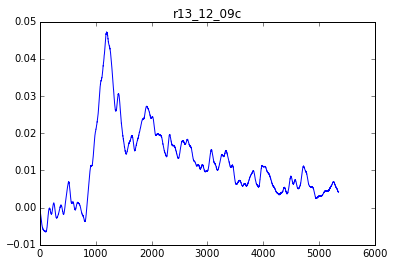

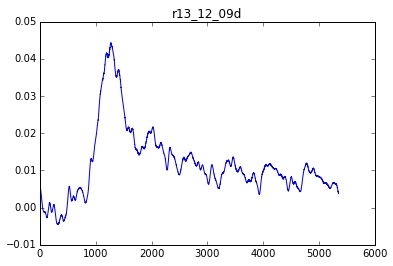

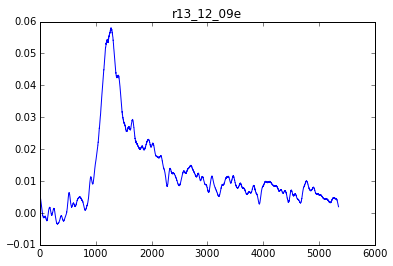

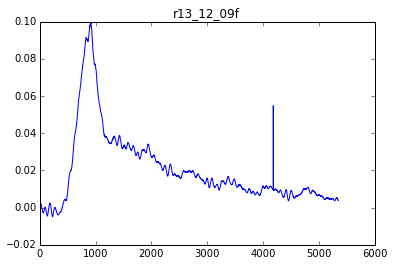

In [133]:
for rindex in ['r13_12_17a',
               'r13_12_17c',
               'r13_12_17d',
               'r13_12_17e',
               'r13_12_17f',
               'r13_12_16a',
               'r13_12_16b',
               'r13_12_16c',
               'r13_12_16d',
               'r13_12_16e',
               'r14_01_14a',
               'r14_01_14b',
               'r14_01_14c',
               'r14_01_14d',
               'r14_01_14e',
               'r13_12_09a',
               'r13_12_09b',
               'r13_12_09c',
               'r13_12_09d',
               'r13_12_09e',
               'r13_12_09f',
              ]:

    cache_path = g.default_processed + rindex + '.hdf5'
    r2 = g.ProcessedRun(cache_path=cache_path)

    mean_signal2 = r2.U[:, :, :].mean(axis=0).mean(axis=0)

    plt.figure()
    plt.title(rindex)
    plt.plot(mean_signal2)